# Setup

In order to run this notebook on Google Colaboratory, it would be easiest to save the downloaded image folder on your Google Drive and mount it to colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install libraries not on colab by default
!pip install segmentation_models_pytorch
!pip install lightning
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=440323efaff34bd8fa42836ce5e00162b1617f8ae6c8202dca56d676a14d78e4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4b23eb349fa789e84a0c46bd6d56c994e58264917b46b3f6c346d612843ba379
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.

In [3]:
import os
from pathlib import Path
import re

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import tv_tensors
from torchvision.transforms import v2

from PIL import Image
import cv2

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Callback
from pytorch_lightning.loggers import WandbLogger
import wandb

from keras import backend as K
import tensorflow as tf
from scipy.ndimage import distance_transform_edt as distance

Set the following variables to the locations of your choice.
* `DATA_DIR`:       this should be set to the image folder downloaded from the AI Crowd platform.
* `LOG_DIR`:        a directory where your model checkpoints and other tracked statistics will be saved.
* `SAVE_DIR`:       a directory where the prediction mask and the ground truth mask will be saved.
* `INPUT_POST`:     a directory containing the predicted masks which you want to post-process.
* `OUTPUT_POST`:    a directory which will contain the output of post-processing
* `INPUT_SUB`:      a directory where the prediction masks to be converted to a csv are saved.
* `OUTPUT_SUB`:        a directory where your submission csv file will be saved.
* `SUB_FILENAME`:   a filename for the submission csv file to generate.

In [ ]:
DATA_DIR = Path('/content/drive/MyDrive/cs-433/ML_2023_/epfml-segmentation')
LOG_DIR = Path('/content/drive/MyDrive/cs-433/ML_2023_/logs')
SAVE_DIR = Path("/content/drive/MyDrive/cs-433/ML_2023_/sub_test/test")
# INPUT_POST is typically SAVE_DIR/pred
INPUT_POST = Path("/content/drive/MyDrive/cs-433/ML_2023_/sub_test/test/pred")
OUTPUT_POST = Path('/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped')
INPUT_SUB = Path('/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped')
OUTPUT_SUB = Path('/content/drive/MyDrive/cs-433/ML_2023_/sub_test/')
SUB_FILENAME = 'submission_test.csv'

We opted in to use Weights & Biases for logging and monitoring our training.

Create an account and get your API key following this instruction: https://docs.wandb.ai/quickstart

In [ ]:
YOUR_API_KEY = ''
wandb.login(key = YOUR_API_KEY)

Change the path below according to where you want to save the predictions in your Google Drive

In [ ]:
# Change the name of the directory according to where you saved the predictions (should be ok like that)
input_dir_post_proc = save_dir + '/pred' # No need to change it

# Change the name of the directory according to where you want to save the predictions after post processing
output_dir_post_proc = "/content/drive/MyDrive/ML_2023/daniel_submission2/post_processing_imgs"

# Change the name of the directory according to where you want to save the final file after post processing
save_dir_fin = "/content/drive/MyDrive/ML_2023/daniel_submission2/file_csv"
# Change the name of the directory according to where you saved the images after post processing (should be ok like that)
img_dir = output_dir_post_proc # no need to change it

submission_filename = "submission.csv"

# Define Transformation

In [ ]:
def get_transform(test=False):
    if test:
        transform = v2.Compose(
            [
                v2.ToImage(),
                v2.ToDtype({tv_tensors.Image: torch.float32,
                            tv_tensors.Mask: torch.float32}, scale=True),
            ]
        )
    else:
        transform = v2.Compose(
            [
                v2.ToImage(), # this has to be before v2.ToDType
                v2.RandomResizedCrop(size=(224, 224), antialias=True),
                v2.RandomPhotometricDistort(p=0.5),
                v2.RandomRotation(degrees=(0, 180)),
                v2.RandomHorizontalFlip(p=0.5),

                v2.ToDtype({tv_tensors.Image: torch.float32,
                            tv_tensors.Mask: torch.float32}, scale=True), # Scaling does not work for TV tensors

            ]
    )
    return transform

In [ ]:
class SatelliteImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, test=False):
        self.transform = transform if transform is not None else v2.ToTensor()
        self.is_test = test
        if test:
            self.data_dir = os.path.join(data_dir, 'test_set_images')
            images = os.listdir(self.data_dir)
            self.images = self.__sort_image_files(images)
        else:
            self.data_dir = os.path.join(data_dir, 'training')
            images = os.listdir(os.path.join(self.data_dir, 'images'))
            self.images = self.__sort_image_files(images)
            self.masks = os.listdir(os.path.join(self.data_dir, 'groundtruth'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = os.path.join(self.data_dir, self.images[idx])
            image = Image.open(img_path).convert("RGB")
            image = self.transform(image)
            mask_gt = one_hot2dist_mask = None
        else:
            img_path = os.path.join(self.data_dir, 'images', self.images[idx])
            mask_path = os.path.join(self.data_dir, 'groundtruth', self.masks[idx])

            # Load the mask and threshold to create binary class labels
            mask = np.array(Image.open(mask_path).convert("L"))[np.newaxis, ...]

            mask_gt = mask / mask.max()
            mask_gt = tv_tensors.Mask(mask_gt)

            one_hot2dist_mask = self.calc_dist_map(mask)
            one_hot2dist_mask = tv_tensors.Mask(one_hot2dist_mask)

        image = Image.open(img_path).convert("RGB")

        if mask_gt is None:
            # not optimized
            to_tensor = v2.ToImage()
            mask_gt = one_hot2dist_mask = to_tensor(image)
            one_hot2dist_mask = to_tensor(image)
            image, mask_gt, one_hot2dist_mask = self.transform(image, torch.zeros_like(mask_gt), torch.zeros_like(one_hot2dist_mask))

        image, mask_gt, one_hot2dist_mask = self.transform(image, mask_gt, one_hot2dist_mask)


        sample = {
            'image': image,
            'mask': mask_gt,
            'dist_mask': one_hot2dist_mask
            }

        return sample

    def calc_dist_map(self, seg):
        res = np.zeros_like(seg)
        posmask = seg.astype(bool)
        if posmask.any():
            negmask = ~posmask
            res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        return res

    def __sort_image_files(self, image_files):
        image_files = list(filter(lambda x: x.endswith('.png'), image_files))
        return sorted(image_files, key=lambda x: int(x.split('_')[1].split('.')[0]))


In [ ]:
#torch.manual_seed(0) # set a seed for reproducibility if necessary
train_transform = get_transform()
test_transform = get_transform(test=True)
dataset = SatelliteImageDataset(DATA_DIR, transform=train_transform)
train_ds, val_ds = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
test_ds = SatelliteImageDataset(DATA_DIR, test=True, transform=test_transform)

Let's do a sanity check:

image shape:  torch.Size([3, 224, 224])
mask shape:  torch.Size([1, 224, 224])
dist mask shape:  torch.Size([1, 224, 224])


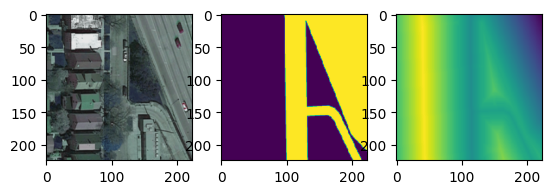

In [ ]:
sample = train_ds[0]
plt.subplot(1, 3, 1)
image = sample['image']
print('image shape: ', image.shape)
imshow(image.permute(1, 2, 0))

plt.subplot(1, 3, 2)
mask = sample['mask']
print('mask shape: ', mask.shape)
imshow(mask.permute(1, 2, 0))

plt.subplot(1, 3, 3)
mask = sample['dist_mask']
print('dist mask shape: ', mask.shape)
imshow(mask.permute(1, 2, 0))

In [ ]:
print(f"Train size: {len(train_ds)}")
print(f"Valid size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_ds, batch_size=20, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_ds, batch_size=50, shuffle=False, num_workers=n_cpu)

Train size: 80
Valid size: 20
Test size: 50


# Model

In [ ]:
class RoadSegmenter(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, loss, alpha=1.0, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameters for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        if loss == "dice":
            self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        elif loss == "jaccard":
            self.loss_fn = smp.losses.JaccardLoss(mode='binary', from_logits=True)
        elif loss == "bce":
            self.loss_fn = torch.nn.BCEWithLogitsLoss()
        elif loss == "surface":
            self.loss_fn = self.eval_surface_loss
        elif loss == "combined":
            self.loss_fn = self.eval_combined_loss
        else:
            raise NotImplementedError(f"Loss {loss} is not implemented.")

        # for version 2 >
        self.tp_ = []
        self.fp_ = []
        self.fn_ = []
        self.tn_ = []
        self.losses = []
        self.dice_losses = []
        self.bd_losses = []

        self.loss_type = loss
        self.alpha = alpha  # Initialize the internal variable for alpha

    def calc_dist_map(self, seg):
        res = np.zeros_like(seg)
        posmask = seg.astype(bool)

        if posmask.any():
            negmask = ~posmask
            res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        return res

    def calc_dist_map_batch(self, y_true):
        y_true_numpy = y_true.numpy()
        return np.array([self.calc_dist_map(y)
                        for y in y_true_numpy]).astype(np.float32)

    def surface_loss(self, y_true, y_pred):
        y_true_dist_map = tf.py_function(func=self.calc_dist_map_batch,
                                        inp=[y_true],
                                        Tout=tf.float32)
        multipled = y_pred * y_true_dist_map
        return K.mean(multipled)

    def eval_surface_loss(self, dist_mask, logits_mask):
        # Convert PyTorch tensors to CPU-based NumPy arrays for TensorFlow operations
        dist_mask_np = dist_mask.cpu().detach().numpy()
        logits_mask_np = logits_mask.sigmoid().cpu().detach().numpy()

        # Calculate surface loss using TensorFlow
        y_true_tf = tf.convert_to_tensor(dist_mask_np, dtype=tf.float32)
        y_pred_tf = tf.convert_to_tensor(logits_mask_np, dtype=tf.float32)
        surface_loss_value = self.surface_loss(y_true_tf, y_pred_tf)
        # Convert TensorFlow output back to PyTorch tensor and move to the correct device
        if not isinstance(surface_loss_value, torch.Tensor):
            surface_loss_value = torch.tensor(surface_loss_value.numpy(),
                                              dtype=torch.float32, device=self.device,
                                              requires_grad=True)
        return surface_loss_value

    def eval_combined_loss(self, dist_mask, logits_mask, gt_mask):
        dice_loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        dice_loss = dice_loss_fn(logits_mask, gt_mask)
        surface_loss_value = self.eval_surface_loss(dist_mask, logits_mask)
        total_loss = self.alpha * dice_loss + (1-self.alpha) * surface_loss_value
        return {'total_loss': total_loss, 'dice_loss': dice_loss, 'surface_loss': surface_loss_value}

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]
        mask = batch["mask"]
        dist_mask = batch["dist_mask"]

        logits_mask = self.forward(image)

        # Dice loss
        if self.loss_type == "dice":
            loss = self.loss_fn(logits_mask, mask)
        elif self.loss_type == "surface":
            loss = self.eval_surface_loss(dist_mask, logits_mask)
        elif self.loss_type == "combined":
            # loss is a dict here
            loss = self.eval_combined_loss(dist_mask, logits_mask, mask)
        else:
            raise NotImplementedError(f"Loss {self.loss_type} is not implemented.")

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        self.tp_.append(tp)
        self.fp_.append(fp)
        self.fn_.append(fn)
        self.tn_.append(tn)
        if self.loss_type == 'combined':
            self.losses.append(loss['total_loss'])
            self.dice_losses.append(loss['dice_loss'])
            self.bd_losses.append(loss['surface_loss'])
            loss = loss['total_loss']
        else:
            self.losses.append(loss)
        return loss


    def shared_epoch_end(self, stage):
      # Aggregate step metrics
        tp_sum = torch.cat(self.tp_)
        fp_sum = torch.cat(self.fp_)
        fn_sum = torch.cat(self.fn_)
        tn_sum = torch.cat(self.tn_)


        # Clear lists for the next epoch
        self.tp_.clear()
        self.fp_.clear()
        self.fn_.clear()
        self.tn_.clear()


        # Calculate IoU using micro reduction
        per_image_iou = smp.metrics.iou_score(tp_sum, fp_sum, fn_sum, tn_sum, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp_sum, fp_sum, fn_sum, tn_sum, reduction="micro")
        per_image_f1 = smp.metrics.f1_score(tp_sum, fp_sum, fn_sum, tn_sum, reduction="micro-imagewise")
        dataset_f1 = smp.metrics.f1_score(tp_sum, fp_sum, fn_sum, tn_sum, reduction="micro")

        # Prepare metrics dictionary
        total_loss_mean = torch.stack(self.losses).mean()
        self.losses.clear()

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_per_image_f1": per_image_f1,
            f"{stage}_dataset_f1": dataset_f1,
            f"{stage}_total_loss": total_loss_mean,
            f"{stage}_alpha": self.alpha,
        }

        if self.loss_type == 'combined':
            dice_loss_mean = torch.stack(self.dice_losses).mean()
            bd_loss_mean = torch.stack(self.bd_losses).mean()
            metrics[f"{stage}_dice_loss"] = dice_loss_mean
            metrics[f"{stage}_bd_loss"] = bd_loss_mean
            self.dice_losses.clear()
            self.bd_losses.clear()
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def on_training_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Alpha Scheduler

In [ ]:
class AlphaUpdater(pl.Callback):
    def __init__(self, step=0.01, init_alpha=1):
        super().__init__()
        self.step = step
        self.init_alpha = init_alpha

    def update_fn(self, pl_module):
        return (pl_module.alpha - self.step) if pl_module.alpha > 0.01 else pl_module.alpha

    def on_fit_start(self, trainer, pl_module):
        if self.init_alpha < pl_module.alpha:
            pl_module.alpha = self.init_alpha

    def on_train_epoch_end(self, trainer, pl_module):
        # Your logic to update alpha here
        new_alpha = self.update_fn(pl_module) # Replace with your logic to compute the new alpha value
        pl_module.alpha = new_alpha

# Training

In [ ]:
epoch = 200
loss = 'dice' # you can choose dice loss or other losses
model = RoadSegmenter(arch="UNet", encoder_name="resnet18", in_channels=3, out_classes=1, loss=loss, encoder_weights='imagenet')
wandb_logger = WandbLogger(project='sat_img', name=f"UNet_res18_epch{epoch}_{loss}_test", save_dir=LOG_DIR)

In [ ]:
alpha_scheduler = AlphaUpdater(init_alpha=1, step=0.005) # change your initial alpha and step
ckpt_callback = ModelCheckpoint(every_n_epochs=50) # only save every 20 epochs

trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=epoch,
    logger=wandb_logger,
    callbacks=[alpha_scheduler, ckpt_callback],
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
    # if resuming the training
    #ckpt_path='/content/drive/MyDrive/cs-433/ML_2023_/logs/sat_img/tiz30vyu/checkpoints/epoch=179-step=360.ckpt'
)
wandb.finish() # need to run this cell after finish training



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: takuya5115 (neurologists). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 14.3 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# Predict on test set and save the result

Use the following cell to load the model weight if necessary

In [ ]:

#This cell is to upload the weights without rerun the training
# load the model
loss = 'dice'
model = RoadSegmenter(arch="UNet", encoder_name="resnet18", in_channels=3, out_classes=1, loss=loss, encoder_weights='imagenet')
# change the path below of your checkpoint
checkpoint_path = "/content/drive/MyDrive/cs-433/ML_2023_/logs/sat_img/y9iwphys/checkpoints/epoch=199-step=800.ckpt"
ckpt = torch.load(checkpoint_path)
model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

Run the following cells to save predictions on the test set.

In [ ]:
# Your existing code to get batch, model, etc.
dataloader = test_dataloader

id = 1
for batch in dataloader:
    with torch.no_grad():
        model.eval()
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()
    gt_masks = batch['mask']

    for (pr_mask, gt_masks) in zip(pr_masks, gt_masks):
        # Convert the prediction mask to a PIL Image
        mask_array = pr_mask.numpy().squeeze()
        gt_mask_array = gt_masks.numpy().squeeze()
        mask_image = Image.fromarray((mask_array * 255).astype(np.uint8))
        # for test set, there are 3 channels so take the first one only
        gt_mask_image = Image.fromarray((gt_mask_array[0, ...] * 255).astype(np.uint8))

        # Save the resized image
        pred_dir = os.path.join(SAVE_DIR, "pred")
        gt_dir = os.path.join(SAVE_DIR, "gt")
        os.makedirs(pred_dir, exist_ok=True)
        os.makedirs(gt_dir, exist_ok=True)
        pred_save_path = os.path.join(pred_dir, f"prediction_{id}.png")
        gt_save_path = os.path.join(gt_dir, f"gt_{id}.png")
        mask_image.save(pred_save_path)
        gt_mask_image.save(gt_save_path)
        id += 1


# Post processing


The following cell will apply morphology transformation (opening) to images in `INPUT_POST` and save them to `OUTPUT_POST`.

In [ ]:
# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_POST):
    os.makedirs(OUTPUT_POST)

# Get the list of image files in the input directory
image_files = [f for f in os.listdir(INPUT_POST) if os.path.isfile(os.path.join(INPUT_POST, f))]

# Define the kernel for sliding operation
kernel_1 = np.ones((3, 3), np.uint8)

# Apply morphologyEx for each image
for image_file in image_files:
    # Read the image
    img = cv2.imread(os.path.join(INPUT_POST, image_file))

    # Apply morphologyEx
    img = cv2.erode(img, kernel_1, iterations=3)
    img = cv2.dilate(img, kernel_1, iterations=4)

    # Save the result with the same filename in the output directory
    output_file = os.path.join(OUTPUT_POST, image_file)
    cv2.imwrite(output_file, img)

# Save for the submission

Create a submission csv file:

In [ ]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename[-8:]).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))

def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

save_path = os.path.join(OUTPUT_SUB, SUB_FILENAME)
image_filenames = []
for i in range(1, 51):
    image_filename = os.path.join(INPUT_SUB, "prediction_" + '%.1d' % i + '.png')
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(save_path, *image_filenames)

/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_1.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_2.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_3.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_4.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_5.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_6.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_7.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_8.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_9.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_10.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_11.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_12.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_13.png
/content/drive/MyDrive/cs-433/ML_2023_/sub_test/pped/prediction_14.png
/content/drive/